# Install

In [1]:
# Libraries you might not have
# !python3 -m pip install --upgrade nbconvert 
# !python3 -m pip install --upgrade nbstripout 
# !python3 -m pip install tomotopy
# !python3 -m pip install sklearn

# Imports

In [2]:
import nltk
# Things to install from nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/dylfox21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dylfox21/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
%load_ext autoreload
%autoreload 2

import tomotopy as tp
from itertools import chain
import tqdm
import pandas as pd
import numpy as np
from collections import defaultdict
import sklearn.preprocessing
import imblearn.over_sampling

import dataloader
import bow
import slda
import post_classifier
import aggregate
import user_classifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Process Train Data

In [5]:
# Uncomment below to process data if you have not already

POSTPATH = './Data/crowd/train/shared_task_posts.csv'
LABELPATH = './Data/crowd/train/crowd_train.csv'
USERPATH = './Data/crowd/train/task_C_train.posts.csv'

users = dataloader.load_user_subset_from_train(USERPATH, subset = 1000)
    
user_to_post, post_to_words, post_to_metadata = dataloader.load_posts(POSTPATH, user_subset = users, append_title = True)
post_to_label = dataloader.load_classification(LABELPATH, user_to_post, post_to_words, post_to_metadata, user_subset = users)
filtered_data, sw_posts, sw_timestamps = dataloader.filter_posts(post_to_label, post_to_metadata, filter_images=True)
print(len(filtered_data))
filtered_data = dataloader.filter_near_SW(filtered_data,post_to_metadata, sw_timestamps)
print(len(filtered_data))

filtered_data = dataloader.filter_stopwords(filtered_data)
sw_posts = dataloader.filter_stopwords(sw_posts)

 24%|██▍       | 490196/2038753 [00:00<00:00, 2435807.91it/s]

Flagging empty posts


  0%|          | 3274/2038753 [00:00<01:02, 32739.33it/s]

Appending Titles


  0%|          | 4518/2038753 [00:00<00:45, 45157.54it/s]

Filtering subset...


  1%|          | 663/57015 [00:00<00:08, 6620.46it/s]

Tokenizing sentences...


 17%|█▋        | 9863/57015 [00:00<00:00, 98627.04it/s]

Normalizing...


  0%|          | 262/57015 [00:00<00:21, 2618.37it/s]

Tokenizing sentences into words...


100%|██████████| 57015/57015 [00:22<00:00, 2542.72it/s]


993


100%|██████████| 22454/22454 [00:00<00:00, 544688.97it/s]

22454
Filtering posts far away from SW posts...
9326


In [11]:
FOLDERPATH = './Processing/crowd_processed/'
dataloader.save_to_folder(FOLDERPATH, user_to_post, post_to_metadata, filtered_data, sw_posts, sw_timestamps)

# Load Process Train Data

In [12]:
FOLDERPATH = './Processing/crowd_processed/'
user_to_post, post_to_metadata, filtered_data, sw_posts, sw_timestamps = dataloader.load_from_folder(FOLDERPATH)

In [13]:
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'a']))
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'b']))
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'c']))
print(len([filtered_data[key] for key in filtered_data.keys() if filtered_data[key][2] == 'd']))
print(len(filtered_data))

258
138
342
1126
9326


# SLDA Model: Train

## Train Topic Model

In [14]:
model = slda.train_slda_model_from_data(filtered_data, topics=40)

100%|██████████| 9326/9326 [00:00<00:00, 49591.55it/s]


Beginning sLDA training...
Iteration: 0	Log-likelihood: -9.876305861994776
Iteration: 100	Log-likelihood: -9.028368161243135
Iteration: 200	Log-likelihood: -8.913993467189561
Iteration: 300	Log-likelihood: -8.855716400352637
Iteration: 400	Log-likelihood: -8.817655633498278
Iteration: 500	Log-likelihood: -8.789588060180847
Iteration: 600	Log-likelihood: -8.7772845216768
Iteration: 700	Log-likelihood: -8.773521723711754
Iteration: 800	Log-likelihood: -8.77084122340052
Iteration: 900	Log-likelihood: -8.765876076381648
Finished Training


## Topic Model Outputs

In [15]:
slda_coefficients = model.get_regression_coef(0)
data = []
for k in range(model.k):
    top_words = model.get_topic_words(k, top_n=40)
    words = [word for (word, float) in top_words]
    words = ", ".join(words)
    data.append([words, slda_coefficients[k]])
    
indices = np.array(slda_coefficients).argsort()
data = np.array(data)
data = data[indices]

pd.DataFrame(data, columns=["Topic", "Suicidality Coefficient"])

,Topic,Suicidality Coefficient
0,"url, us, min, survey, gt95, person, short, stu...",-4.383256912231445
1,"person, psn, ps4, add, lvl, vog, looking, hm, ...",-3.6554858684539795
2,"english, language, person, german, time, nativ...",-3.6365163326263428
3,"person, god, people, believe, book, church, at...",-3.598055601119995
4,"person, vs, persons, team, 1, characters, char...",-3.536412000656128
5,"baby, dog, family, like, husband, puppy, dogs,...",-3.441037654876709
6,"car, bike, points, city, area, experience, new...",-3.4356982707977295
7,"person, gt, bra, fit, size, file, bras, list, ...",-3.2810873985290527
8,"buy, price, sell, person, stock, options, buyi...",-3.2133429050445557
9,"person, keys, w, h, url, dragon, killed, blue,...",-3.2039291858673096


In [16]:
# Uncomment to print example of overly negative topic
print(data[np.shape(data)[0]-1][0])

im, dont, know, like, want, feel, life, really, cant, friends, never, ive, even, get, going, go, much, people, years, way, things, love, one, help, need, always, tell, didnt, friend, time, mom, away, fucking, everything, hate, shit, parents, back, day, said


## sLDA Features: Train

In [17]:
vector_train = slda.get_topic_vecs(model, filtered_data)

  0%|          | 3/9326 [00:00<05:25, 28.67it/s]

Getting topic distributions...


100%|██████████| 9326/9326 [04:08<00:00, 37.53it/s]


In [18]:
#Uncomment to print example feature vector
print(vector_train['hw4uh'][0])

[0.0016523764934390783, 0.0005985179450362921, 0.00014636835840065032, 0.00031015442800708115, 0.0006073200493119657, 0.4037897288799286, 0.03778862580657005, 0.00015629178960807621, 0.08318338543176651, 0.00034016557037830353, 0.0006263265968300402, 0.00044573316699825227, 0.0002578873827587813, 0.0017927708104252815, 0.3473002016544342, 0.000289768329821527, 0.017029784619808197, 0.016991425305604935, 0.00048306502867490053, 0.0002846891002263874, 0.0009299757075496018, 0.00029477986390702426, 0.0007394409039989114, 0.03340107575058937, 0.0015970715321600437, 0.00019966346735600382, 0.017180660739541054, 0.0003156775492243469, 0.0005604436155408621, 0.00046880223089829087, 0.0009860373102128506, 0.00048259063623845577, 0.022451763972640038, 0.0006405130843631923, 0.0001896763133117929, 0.000688247149810195, 0.003109503770247102, 0.00023085711291059852, 0.001312675653025508, 0.00014599169662687927]


# BOW

In [19]:
word2index,index2word = bow.generate_vocabulary(filtered_data)
pca_model, vector_train_bow = bow.get_PCA_vectors_from_post_set(filtered_data, word2index)

100%|██████████| 9326/9326 [01:50<00:00, 84.08it/s]


# Post Classifier: Train

## Post Classifier: Train

In [20]:
def minmax_norm(arr):
    
    return (arr - np.min(arr))/(np.max(arr) -np.min(arr))

In [21]:
#USE JUST SLDA
X_train = np.array([ vector_train[key][0] for key in vector_train.keys()])
y_train = np.array([ vector_train[key][1] for key in vector_train.keys()])
y_train = y_train.reshape(np.shape(y_train)[0])

In [328]:
#USE JUST BOW
X_train = np.array([ vector_train_bow[key][0] for key in vector_train_bow.keys()])
y_train = np.array([ vector_train_bow[key][1] for key in vector_train_bow.keys()])
y_train = y_train.reshape(np.shape(y_train)[0])


In [146]:
#USE SLDA + BOW
X_train = np.array([ np.concatenate([minmax_norm(vector_train[key][0]),minmax_norm(vector_train_bow[key][0])]) for key in vector_train.keys()])
y_train = np.array([ vector_train[key][1] for key in vector_train.keys()])

y_train = y_train.reshape(np.shape(y_train)[0])

### Oversampling

In [147]:
ros = imblearn.over_sampling.RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [148]:
print(np.shape(X_train))
print(np.shape(y_train))

(16400, 80)
(16400,)


### Logistic Regression

In [24]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("LogReg")
#param_dict = {'C':[0.2,0.5,0.7,1,1.5,2,5]}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

#RUN WITH OPTIMAL PARAMETERS
p_clf = post_classifier.PostClassification("LogReg")
p_clf.train(X_train, y_train)


### Linear SVM

In [ ]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("LinearSVM")
#param_dict = {'C':[0.2,0.5,1,2]}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

p_clf = post_classifier.PostClassification("LinearSVM")
p_clf.train(X_train, y_train)

### RBF SVM

In [149]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("RbfSVM")
#param_dict = {'C':[0.5,1,2,5]}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

p_clf = post_classifier.PostClassification("RbfSVM")
p_clf.train(X_train, y_train)

### AdaBoost

In [123]:
p_clf = post_classifier.PostClassification("AdaBoost")
p_clf.train(X_train, y_train)

### Random Forest

In [102]:
p_clf = post_classifier.PostClassification("RandomForest")
p_clf.train(X_train, y_train)

### Multi-layer Perceptron

In [55]:
#UNCOMMENT TO RUN GRID SEARCH CV
#p_clf = post_classifier.PostClassification("MLP")
#param_dict = {'hidden_layer_sizes':[(64,64),(64,64,64),(32,32), (32,32,32)], 'learning_rate': ('constant', 'adaptive')}
#p_clf.train_grid_search_CV(X_train, y_train, param_dict, groups=5)

p_clf = post_classifier.PostClassification("MLP")
p_clf.train(X_train, y_train)

Iteration 1, loss = 0.63991863
Iteration 2, loss = 0.56435977
Iteration 3, loss = 0.55365331
Iteration 4, loss = 0.54670170
Iteration 5, loss = 0.53902474
Iteration 6, loss = 0.52865518
Iteration 7, loss = 0.51979170
Iteration 8, loss = 0.51033889
Iteration 9, loss = 0.50233674
Iteration 10, loss = 0.49163290
Iteration 11, loss = 0.48332509
Iteration 12, loss = 0.47641719
Iteration 13, loss = 0.46728708
Iteration 14, loss = 0.45809468
Iteration 15, loss = 0.44866591
Iteration 16, loss = 0.44059495
Iteration 17, loss = 0.43422832
Iteration 18, loss = 0.42844304
Iteration 19, loss = 0.42118554
Iteration 20, loss = 0.41766574
Iteration 21, loss = 0.41726597
Iteration 22, loss = 0.40286767
Iteration 23, loss = 0.39766109
Iteration 24, loss = 0.39342225
Iteration 25, loss = 0.38631937
Iteration 26, loss = 0.38319653
Iteration 27, loss = 0.37670835
Iteration 28, loss = 0.37449011
Iteration 29, loss = 0.36913125
Iteration 30, loss = 0.36810826
Iteration 31, loss = 0.36191303
Iteration 32, los

## Predict Post Classifier: Train

In [150]:
y_pred_train = p_clf.test(X_train)

In [151]:
p_clf.get_metrics(y_train, y_pred_train)

{'accuracy': 0.8107317073170732,
 'precision': 0.7859708193041527,
 'recall': 0.8540243902439024,
 'f1': 0.8185856224430158}

In [152]:
print(sum(y_pred_train))
print(sum(y_train))

8910
8200


# User Classfier: Train

## Aggregate: Train

In [153]:
# change y from a, b, c, d, control to -, 1
user_to_y_train = defaultdict(int)
for data in tqdm.tqdm(filtered_data.keys()):
    user_to_y_train[filtered_data[data][0]] = (1 if filtered_data[data][2] == 'd' else 0)

100%|██████████| 9326/9326 [00:00<00:00, 1587889.87it/s]


In [154]:
post_to_uypred_train = defaultdict(list)

for i, post_id in enumerate(vector_train.keys()):
    user_id = filtered_data[post_id][0]
    post_to_uypred_train[post_id] = [user_id, y_pred_train[i]]

In [155]:
user_to_post_label_train = aggregate.aggregate_posts(FOLDERPATH, post_to_uypred_train)

Saved aggreagation of user to post labels...


## Argmax: Train

In [156]:
u_clf_train = user_classifier.UserClassification(user_to_post_label_train)
user_to_ypred_train = u_clf_train.argmax()

In [157]:
user_y_train = []
user_y_pred_train = []
for user_id in user_to_ypred_train:
    user_y_train.append(user_to_y_train[user_id])
    user_y_pred_train.append(user_to_ypred_train[user_id])

In [158]:
u_clf_train.get_metrics(user_y_train, user_y_pred_train)

{'accuracy': 0.7830985915492957,
 'precision': 0.46558704453441296,
 'recall': 0.8394160583941606,
 'f1': 0.5989583333333333}

# Process Data: Test

In [34]:
POSTPATH2 = './Data/crowd/test/shared_task_posts_test.csv'
LABELPATH2 = './Data/crowd/test/crowd_test_C.csv'
USERPATH2 = './Data/crowd/test/task_C_test.posts.csv'
    
user_to_post_test, post_to_words_test, post_to_metadata_test = dataloader.load_posts(POSTPATH2, append_title = True)
post_to_label_test = dataloader.load_classification(LABELPATH2, user_to_post_test, post_to_words_test, post_to_metadata_test)
filtered_data_test, sw_posts_test, sw_timestamps_test = dataloader.filter_posts(post_to_label_test, post_to_metadata_test, filter_images = True)
print(len(filtered_data_test))
filtered_data_test = dataloader.filter_near_SW(filtered_data_test, post_to_metadata_test, sw_timestamps_test)
print(len(filtered_data_test))

filtered_data_test = dataloader.filter_stopwords(filtered_data_test)
sw_posts_test = dataloader.filter_stopwords(sw_posts_test)

100%|██████████| 14447/14447 [00:00<00:00, 76060.49it/s]

Flagging empty posts
Appending Titles
Tokenizing sentences...



  0%|          | 0/14447 [00:00<?, ?it/s]

Normalizing...
Tokenizing sentences into words...


100%|██████████| 6250/6250 [00:00<00:00, 815377.92it/s]

249
6250
Filtering posts far away from SW posts...
2145


In [35]:
FOLDERPATH2 = './Processing/crowd_processed_test/'
dataloader.save_to_folder(FOLDERPATH2, user_to_post_test, post_to_metadata_test, filtered_data_test, sw_posts_test, sw_timestamps_test)

# Load Process Data: Test

In [36]:
FOLDERPATH2 = './Processing/crowd_processed_test/'
user_to_post_test, post_to_metadata_test, filtered_data_test, sw_posts_test, sw_timestamps_test = dataloader.load_from_folder(FOLDERPATH2)

In [37]:
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'a']))
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'b']))
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'c']))
print(len([filtered_data_test[key] for key in filtered_data_test.keys() if filtered_data_test[key][2] == 'd']))
print(len(filtered_data_test))

1749
38
140
218
2145


# Feature Extraction: Test

## sLDA

In [39]:
X_test, y_test = slda.vectorize_data_set(model, FOLDERPATH2)

  0%|          | 3/2145 [00:00<01:13, 29.29it/s]

Getting topic distributions...


100%|██████████| 2145/2145 [00:59<00:00, 35.87it/s]


In [40]:
vector_test = slda.get_topic_vecs(model, filtered_data_test)

  0%|          | 4/2145 [00:00<00:58, 36.34it/s]

Getting topic distributions...


100%|██████████| 2145/2145 [00:57<00:00, 37.15it/s]


## BOW

In [41]:
_, vector_test_bow = bow.get_PCA_vectors_from_post_set(filtered_data_test, word2index, pca_model=pca_model)

100%|██████████| 2145/2145 [00:24<00:00, 86.90it/s]


In [ ]:
# USE JUST BOW
X_test = np.array([ vector_test_bow[key][0] for key in vector_test_bow.keys()])
y_test = np.array([ vector_test_bow[key][1] for key in vector_test_bow.keys()])
y_test = y_test.reshape(np.shape(y_test)[0])

In [159]:
#USE SLDA + BOW
X_test = np.array([ np.concatenate([minmax_norm(vector_test[key][0]),minmax_norm(vector_test_bow[key][0])]) for key in vector_test.keys()])
y_test = np.array([ vector_test[key][1] for key in vector_test.keys()])

y_test = y_test.reshape(np.shape(y_test)[0])

In [160]:
print(np.shape(X_test))
print(np.shape(y_test))

(2145, 80)
(2145,)


# Post Classifier: Test

## Predict Post Classifier: Test

In [133]:
y_pred_test = p_clf.test(X_test)

In [134]:
p_clf.get_metrics(y_test, y_pred_test)

{'accuracy': 0.6638694638694639,
 'precision': 0.11485451761102604,
 'recall': 0.3440366972477064,
 'f1': 0.1722158438576349}

In [135]:
print(sum(y_pred_test))
print(sum(y_test))

653
[218]


# User Classifier: Test

## Aggregate: Test

In [136]:
# change y from a, b, c, d, control to -, 1
user_to_y_test = defaultdict(int)
for data in tqdm.tqdm(filtered_data_test.keys()):
    user_to_y_test[filtered_data_test[data][0]] = (1 if filtered_data_test[data][2] == 'd' else 0)

100%|██████████| 2145/2145 [00:00<00:00, 1607429.35it/s]


In [137]:
len(filtered_data_test)

2145

In [138]:
len(vector_test)

2145

In [139]:
post_to_uypred_test = defaultdict(list)

for i, post_id in enumerate(vector_test.keys()):
    user_id = filtered_data_test[post_id][0]
    post_to_uypred_test[post_id] = [user_id, y_pred_test[i]]

In [140]:
user_to_post_label_test = aggregate.aggregate_posts(FOLDERPATH2, post_to_uypred_test)

Saved aggreagation of user to post labels...


## Argmax: Test

In [141]:
u_clf_test = user_classifier.UserClassification(user_to_post_label_test)
user_to_ypred_test = u_clf_test.argmax()

In [142]:
user_y_test = []
user_y_pred_test = []
for user_id in user_to_ypred_test:
    user_y_test.append(user_to_y_test[user_id])
    user_y_pred_test.append(user_to_ypred_test[user_id])

In [143]:
u_clf_test.get_metrics(user_y_test, user_y_pred_test)

{'accuracy': 0.7272727272727273,
 'precision': 0.3111111111111111,
 'recall': 0.45161290322580644,
 'f1': 0.3684210526315789}

## Threshold: Test

In [144]:
u_clf_test = user_classifier.UserClassification(user_to_post_label_test)

percent:  [0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]
f_score:  [0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.3880597014925373, 0.393939393939394, 0.36923076923076925, 0.36923076923076925, 0.38095238095238093, 0.38095238095238093, 0.36666666666666664, 0.36666666666666664, 0.36666666666666664, 0.3728813559322034, 0.3728813559322034, 0.3728813559322034, 0.3728813559322034, 0.3636363636363636, 0.3636363636363636, 0.3636363636363636, 0.3636363636363636, 0.37037037037037035, 0.37037037037037035, 0.37037037037037035, 0.3773584905660377, 0.39215686274509803, 0.39215686274509803, 0.39215686274509803, 0.39215686274509803, 0.39215686274509803, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.3673469387755102, 0.3673469387755102, 0.36734693877

/home/dylfox21/miniconda2/envs/cmsc773/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


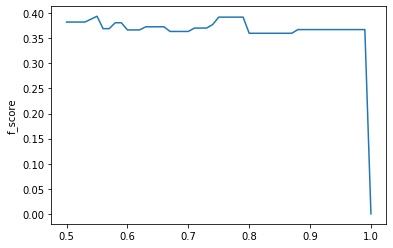

{'accuracy': 0.7727272727272727,
 'precision': 0.37142857142857144,
 'recall': 0.41935483870967744,
 'f1': 0.393939393939394}

In [145]:
u_clf_test.find_threshold(user_to_y_test)

In [99]:
user_to_ypred_test = u_clf_test.minimum(1)

In [100]:
user_y_test = []
user_y_pred_test = []
for user_id in user_to_ypred_test:
    user_y_test.append(user_to_y_test[user_id])
    user_y_pred_test.append(user_to_ypred_test[user_id])

In [101]:
u_clf_test.get_metrics(user_y_test, user_y_pred_test)

{'accuracy': 0.26136363636363635,
 'precision': 0.17647058823529413,
 'recall': 0.8709677419354839,
 'f1': 0.29347826086956524}